<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [1]:
%pip install deap

In [2]:
%pip install statstests

In [3]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para Modelagem
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

# Bibliotecas para Otimização
import deap
import random
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool
from deap import base, creator, tools, algorithms
from sklearn.metrics import roc_auc_score, mean_squared_error

filterwarnings('ignore')

In [19]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features_60min.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df = pd.read_parquet('/content/datasets/transactions_features_60min.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [21]:
df.head()

,date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,...,category_government_utilities,category_travel_hospitality,category_health_medical,category_professional_business_services,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_manufacturing_industrial,category_retail_home_garden,category_personal_services
0,2010-01-01 00:00:00,26,0,23.964231,38.352274,-0.642206,1.203337,53.384615,14.721622,1.192134,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1,2010-01-01 01:00:00,22,0,48.329545,68.191605,1.513112,3.528357,54.909091,13.738750,0.901237,...,0.14,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,2010-01-01 02:00:00,25,0,41.120400,51.744504,1.585762,1.982138,51.680000,17.199128,1.203023,...,0.04,0.04,0.04,0.04,0.04,0.00,0.0,0.0,0.0,0.0
3,2010-01-01 03:00:00,21,0,34.030952,63.774164,-0.294912,2.162171,52.333333,16.103830,0.644560,...,0.05,0.00,0.05,0.00,0.05,0.00,0.0,0.0,0.0,0.0
4,2010-01-01 04:00:00,16,0,37.382500,45.371877,1.818162,3.093740,54.687500,13.636807,0.636163,...,0.00,0.00,0.06,0.00,0.00,0.06,0.0,0.0,0.0,0.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86151 entries, 0 to 86150
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              86151 non-null  datetime64[us]
 1   transactions                             86151 non-null  uint32        
 2   frauds                                   86151 non-null  int32         
 3   mean_amount                              86151 non-null  float64       
 4   std_amount                               86140 non-null  float64       
 5   skew_amount                              86140 non-null  float64       
 6   kurtosis_amount                          86140 non-null  float64       
 7   mean_current_age                         86151 non-null  float64       
 8   std_current_age                          86140 non-null  float64       
 9   skew_current_age                       

In [23]:
df.describe()

,date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,...,category_government_utilities,category_travel_hospitality,category_health_medical,category_professional_business_services,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_manufacturing_industrial,category_retail_home_garden,category_personal_services
count,86151,86151.000000,86151.000000,86151.000000,86140.000000,86140.000000,86140.000000,86151.000000,86140.000000,86140.000000,...,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000,86151.000000
mean,2014-12-01 15:27:28.250165,103.480668,0.154752,46.634533,79.750805,1.717377,14.813621,53.812155,15.487478,0.532447,...,0.032186,0.005773,0.064984,0.008595,0.008329,0.004772,0.000520,0.013491,0.028329,0.008181
min,2010-01-01 00:00:00,1.000000,0.000000,-422.000000,15.491699,-5.496012,-2.000000,26.000000,4.041452,-1.436190,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-17 05:30:00,33.000000,0.000000,37.240395,56.333706,0.344491,3.415099,52.581116,14.653634,0.399127,...,0.010000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000
50%,2014-12-01 15:00:00,94.000000,0.000000,44.672475,70.898425,1.439883,8.598265,53.891566,15.585020,0.528142,...,0.030000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000
75%,2017-05-17 13:30:00,164.000000,0.000000,52.975841,94.317958,2.890733,17.565400,55.113333,16.418038,0.663956,...,0.040000,0.000000,0.080000,0.010000,0.010000,0.010000,0.000000,0.010000,0.040000,0.010000
max,2019-10-31 23:00:00,245.000000,9.000000,1501.560000,1323.626113,13.720912,190.700042,82.000000,26.279817,2.306685,...,0.440000,1.000000,0.420000,0.270000,0.250000,0.200000,0.670000,1.000000,1.000000,0.170000
std,NaN,62.285940,0.594059,17.069769,35.100653,2.401495,18.761427,2.257235,1.547826,0.248371,...,0.032739,0.016522,0.036345,0.016578,0.013366,0.010354,0.003729,0.025988,0.026552,0.010502


In [24]:
df['frauds'].value_counts(normalize=True)

,proportion
frauds,
0,0.911562
1,0.048612
2,0.024178
3,0.009298
4,0.003726
5,0.001463
6,0.000731
7,0.000209
8,0.000163


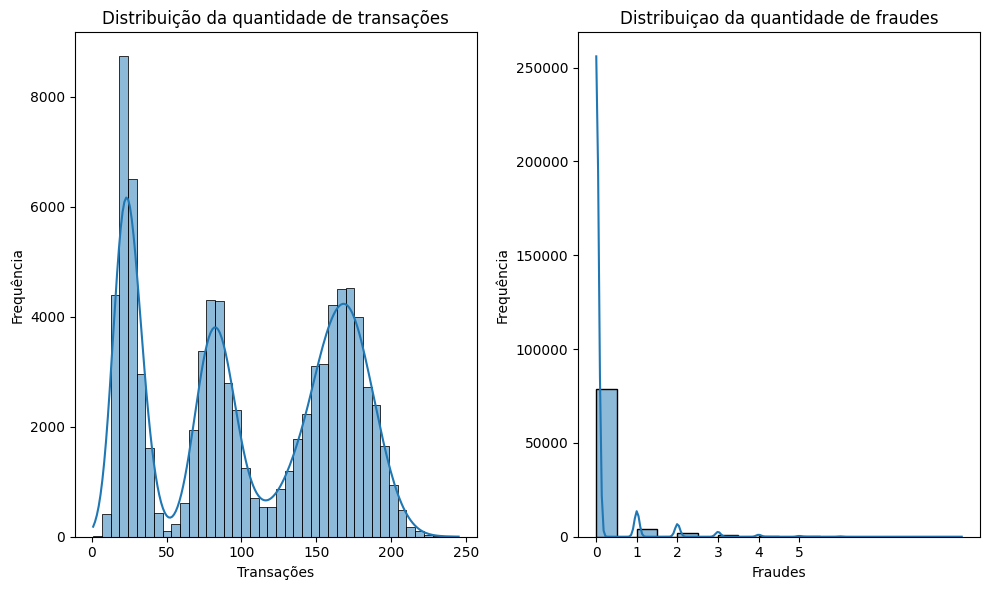

In [25]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title('Distribuição da quantidade de transações')
sns.histplot(df['transactions'], kde=True)
plt.xlabel('Transações')
plt.ylabel('Frequência')

plt.subplot(122)
plt.title('Distribuiçao da quantidade de fraudes')
sns.histplot(df['frauds'], kde=True)
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, 6, 1))

plt.tight_layout()
plt.show()

## Implementação de Modelos

### Função de Comparação

In [26]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [27]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [28]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [29]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.154752,0.352906


Há indícios de superdispersão.

In [30]:
all_features = df.drop(columns=['frauds', 'date_window']).columns.to_list()
all_features[0:3]

['transactions', 'mean_amount', 'std_amount']

In [31]:
features_completa_formula = 'frauds ~ ' + ' + '.join(all_features)
features_completa_formula

'frauds ~ transactions + mean_amount + std_amount + skew_amount + kurtosis_amount + mean_current_age + std_current_age + skew_current_age + kurtosis_current_age + mean_per_capita_income + std_per_capita_income + skew_per_capita_income + kurtosis_per_capita_income + mean_total_debt + std_total_debt + skew_total_debt + kurtosis_total_debt + mean_credit_score + std_credit_score + skew_credit_score + kurtosis_credit_score + mean_num_credit_cards + std_num_credit_cards + skew_num_credit_cards + kurtosis_num_credit_cards + mean_credit_limit + std_credit_limit + skew_credit_limit + kurtosis_credit_limit + use_chip_online_transaction + use_chip_swipe_transaction + use_chip_chip_transaction + gender_female + card_brand_amex + card_brand_mastercard + card_brand_visa + card_brand_discover + card_type_credit + card_type_debit_prepaid + card_type_debit + has_chip_yes + online_sales_no + category_food_beverage + category_retail_general_department + category_transportation_logistics + category_financ

In [32]:
modelo_poison_simple = smf.glm(formula='frauds ~ transactions', data=df, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86151
Model:                            GLM   Df Residuals:                    86149
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38269.
Date:                Tue, 27 May 2025   Deviance:                       58459.
Time:                        02:47:40   Pearson chi2:                 1.61e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1142
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.1217      0.032   -129.039      0.000      -4.184      -4.059
transactions     0.0170      0.000     86.113      0.000       0.017       0.017
================================================================================
"""

Observações do modelo simples

* Intercepto e variavel `transactions` são estatisticamente significantes
* O Log-Likelihood é alto
* Pseudo R-Squ. (CS) indique que apenas a variavel `transaction` explica menos que 3% da variância na contagem de fraudes.



In [33]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=df, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86080
Model Family:                 Poisson   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36749.
Date:                Tue, 27 May 2025   Deviance:                       55422.
Time:                        02:47:44   Pearson chi2:                 1.59e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1448
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.0489      4.896      0.010      0.992      -9.547       9.644
transactions                                0.0204      0.000     65.421      0.000       0.020       0.021
mean_amount                                 0.0047      0.001      5.150      0.000       0.003       0.006
std_amount                                  0.0016      0.000      3.242      0.001       0.001       0.003
skew_amount                                 0.0304      0.007      4.427      0.000       0.017       0.044
kurtosis_amount                            -0.0033      0.001     -4.017      0.000      -0.005      -0.002
mean_current_age                            0.0500      0.008      6.374      0.000       0.035       0.065
std_current_age                            -0.1548      0.011    -14.039      0.000      -0.176      -0.133
skew_current_age                            1.3475      0.095     14.152      0.000       1.161       1.534
kurtosis_current_age                       -0.9170      0.046    -19.774      0.000      -1.008      -0.826
mean_per_capita_income                   4.539e-06   1.49e-05      0.304      0.761   -2.47e-05    3.38e-05
std_per_capita_income                    7.628e-07   8.69e-06      0.088      0.930   -1.63e-05    1.78e-05
skew_per_capita_income                      0.1329      0.038      3.474      0.001       0.058       0.208
kurtosis_per_capita_income                 -0.0144      0.003     -4.209      0.000      -0.021      -0.008
mean_total_debt                          4.405e-06    3.4e-06      1.295      0.195   -2.26e-06    1.11e-05
std_total_debt                          -5.488e-06    3.7e-06     -1.485      0.138   -1.27e-05    1.76e-06
skew_total_debt                             0.1831      0.075      2.426      0.015       0.035       0.331
kurtosis_total_debt                        -0.0172      0.008     -2.037      0.042      -0.034      -0.001
mean_credit_score                          -0.0098      0.001     -6.730      0.000      -0.013      -0.007
std_credit_score                           -0.0045      0.002     -2.186      0.029      -0.009      -0.000
skew_credit_score                           0.0701      0.055      1.283      0.199      -0.037       0.177
kurtosis_credit_score                       0.0520      0.022      2.342      0.019       0.008       0.096
mean_num_credit_cards                       0.3823      0.068      5.615      0.000       0.249       0.516
std_num_credit_cards                       -0.4333      0.098     -4.415      0.000      -0.626      -0.241
skew_num_credit_cards                       0.3717      0.066      5.610      0.000       0.242       0.502
kurtosis_num_credit_cards                   0.0123      0.0

In [34]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.007      
Dependent Variable:     ystar            AIC:                         621997.2157
Date:                   2025-05-27 02:47 BIC:                         622006.5795
No. Observations:       86140            Log-Likelihood:              -3.1100e+05
Df Model:               1                F-statistic:                 583.4      
Df Residuals:           86139            Prob (F-statistic):          1.85e-128  
R-squared (uncentered): 0.007            Scale:                       80.068     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.2197         0.1333       24.1532       0.0000       2.9584    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

In [35]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('skew_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('skew_current_age') + Q('kurtosis_current_age') + Q('mean_per_capita_income') + Q('std_per_capita_income') + Q('skew_per_capita_income') + Q('kurtosis_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('skew_total_debt') + Q('kurtosis_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('skew_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('std_credit_limit') + Q('skew_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_online_transaction') + Q('use_chip_swipe_transaction') + Q('use_chip_chip_transaction') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_mastercard') + Q('card_brand_visa') + Q('car

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86098
Model Family:                 Poisson   Df Model:                           41
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36761.
Date:                Tue, 27 May 2025   Deviance:                       55446.
Time:                        02:48:40   Pearson chi2:                 1.60e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1446
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       11.5299      1.261      9.143      0.000       9.058      14.002
Q('transactions')                                0.0205      0.000     68.593      0.000       0.020       0.021
Q('mean_amount')                                 0.0047      0.001      5.509      0.000       0.003       0.006
Q('std_amount')                                  0.0015      0.000      3.104      0.002       0.001       0.002
Q('skew_amount')                                 0.0319      0.007      4.694      0.000       0.019       0.045
Q('kurtosis_amount')                            -0.0033      0.001     -4.096      0.000      -0.005      -0.002
Q('mean_current_age')                            0.0451      0.007      6.346      0.000       0.031       0.059
Q('std_current_age')                            -0.1580      0.011    -14.627      0.000      -0.179      -0.137
Q('skew_current_age')                            1.3155      0.094     13.980      0.000       1.131       1.500
Q('kurtosis_current_age')                       -0.9056      0.045    -20.118      0.000      -0.994      -0.817
Q('skew_per_capita_income')                      0.1438      0.030      4.841      0.000       0.086       0.202
Q('kurtosis_per_capita_income')                 -0.0155      0.003     -5.057      0.000      -0.021      -0.009
Q('skew_total_debt')                             0.0316      0.013      2.421      0.015       0.006       0.057
Q('mean_credit_score')                          -0.0098      0.001     -6.806      0.000      -0.013      -0.007
Q('std_credit_score')                           -0.0055      0.002     -3.143      0.002      -0.009      -0.002
Q('kurtosis_credit_score')                       0.0325      0.015      2.162      0.031       0.003       0.062
Q('mean_num_credit_cards')                       0.3830      0.066      5.801      0.000       0.254       0.512
Q('std_num_credit_cards')                       -0.4217      0.087     -4.832      0.000      -0.593      -0.251
Q('skew_num_credit_cards')                       0.3831      0.046      8.396      0.000       0.294       0.473
Q('std_credit_limit')                        -3.673e-05   6.36e-06     -5.780      0.000   -4.92e-05   -2.43e-05
Q('kurtosis_credit_limit')                       0.0073      0.001      5.545      0.000       0.005       0.010
Q('use_chip_swipe_transaction')                -11.3287      0.285    -39.680      0.000     -11.888     -10.769
Q('use_chip_chip_transaction')                 -11.0020      0.290    -37.959      0.000     -11.570     -10.434
Q('gender_female')                               0.9420      0.173      5.445      0.000       0.603       1.281
Q('card_brand_amex')            

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [36]:
overdisp(modelo_poisson_stepswise, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.006      
Dependent Variable:     ystar            AIC:                         624938.1633
Date:                   2025-05-27 02:49 BIC:                         624947.5271
No. Observations:       86140            Log-Likelihood:              -3.1247e+05
Df Model:               1                F-statistic:                 564.4      
Df Residuals:           86139            Prob (F-statistic):          2.32e-124  
R-squared (uncentered): 0.007            Scale:                       82.849     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.2225         0.1356       23.7574       0.0000       2.9566    

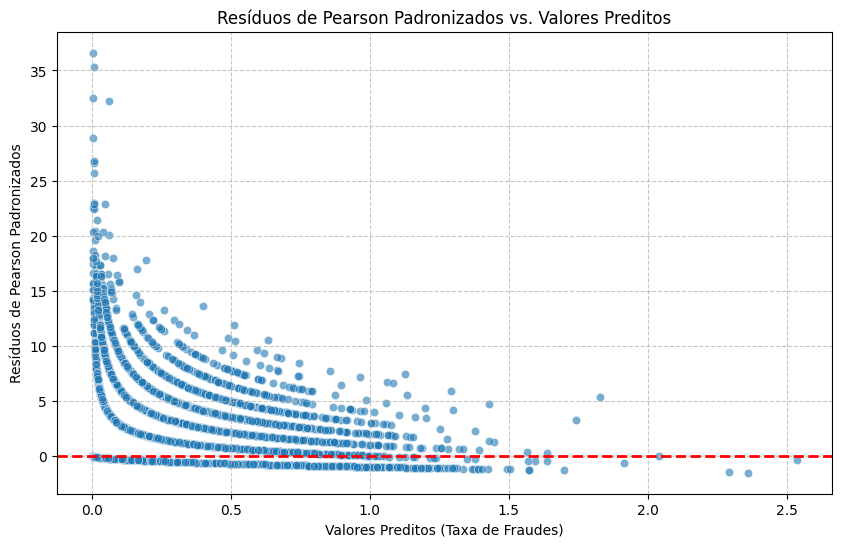

In [37]:
pearson_residuals = modelo_poisson_stepswise.resid_pearson
fitted_values = modelo_poisson_stepswise.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Valores Preditos (Taxa de Fraudes)")
plt.ylabel("Resíduos de Pearson Padronizados")
plt.title("Resíduos de Pearson Padronizados vs. Valores Preditos")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [38]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,-4.1217***,0.0489,11.5299***
,(0.0319),(4.8957),(1.2611)
transactions,0.0170***,0.0204***,
,(0.0002),(0.0003),
mean_amount,,0.0047***,
,,(0.0009),
std_amount,,0.0016***,
,,(0.0005),
skew_amount,,0.0304***,
,,(0.0069),


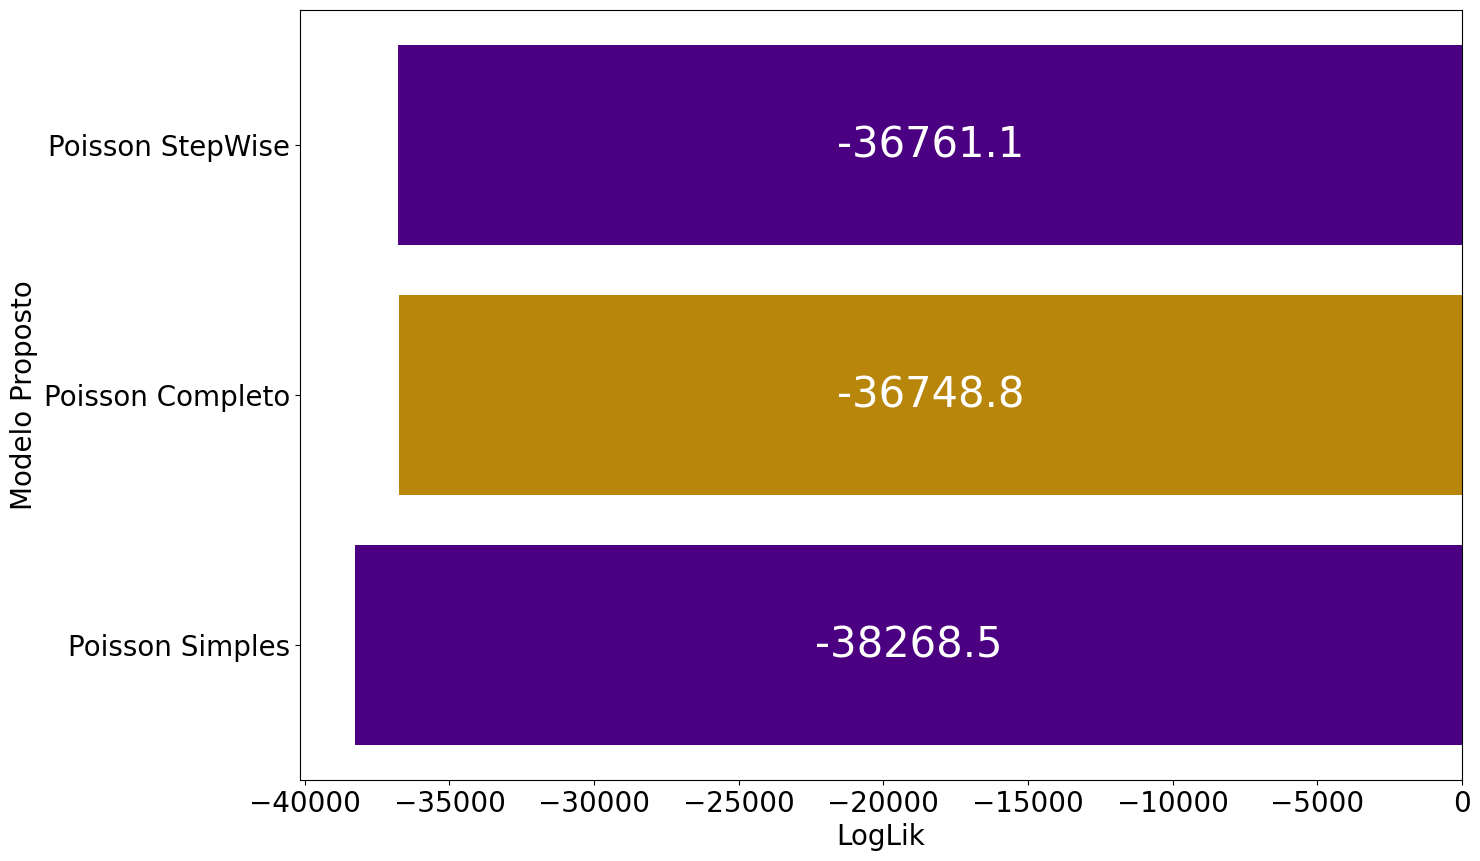

In [39]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [40]:
modelo_binomialneg_simples = smf.glm(formula='frauds ~ transactions', data=df, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86151
Model:                            GLM   Df Residuals:                    86149
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34650.
Date:                Tue, 27 May 2025   Deviance:                       43251.
Time:                        02:50:10   Pearson chi2:                 1.39e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1001
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.1303      0.033   -123.695      0.000      -4.196      -4.065
transactions     0.0171      0.000     80.792      0.000       0.017       0.017
================================================================================
"""

In [41]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=df, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86080
Model Family:        NegativeBinomial   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33458.
Date:                Tue, 27 May 2025   Deviance:                       40870.
Time:                        02:50:27   Pearson chi2:                 1.37e+05
No. Iterations:                    20   Pseudo R-squ. (CS):             0.1246
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -1.2018      5.578     -0.215      0.829     -12.134       9.731
transactions                                0.0202      0.000     57.654      0.000       0.020       0.021
mean_amount                                 0.0055      0.001      4.797      0.000       0.003       0.008
std_amount                                  0.0015      0.001      2.715      0.007       0.000       0.003
skew_amount                                 0.0239      0.008      3.082      0.002       0.009       0.039
kurtosis_amount                            -0.0028      0.001     -2.993      0.003      -0.005      -0.001
mean_current_age                            0.0570      0.009      6.563      0.000       0.040       0.074
std_current_age                            -0.1570      0.012    -12.766      0.000      -0.181      -0.133
skew_current_age                            1.4459      0.106     13.688      0.000       1.239       1.653
kurtosis_current_age                       -0.9331      0.051    -18.247      0.000      -1.033      -0.833
mean_per_capita_income                  -4.445e-06   1.66e-05     -0.268      0.789    -3.7e-05    2.81e-05
std_per_capita_income                     2.45e-07   9.75e-06      0.025      0.980   -1.89e-05    1.94e-05
skew_per_capita_income                      0.1422      0.043      3.338      0.001       0.059       0.226
kurtosis_per_capita_income                 -0.0153      0.004     -3.987      0.000      -0.023      -0.008
mean_total_debt                          7.023e-06   3.77e-06      1.861      0.063   -3.72e-07    1.44e-05
std_total_debt                            -7.4e-06   4.11e-06     -1.800      0.072   -1.55e-05    6.56e-07
skew_total_debt                             0.2092      0.084      2.496      0.013       0.045       0.373
kurtosis_total_debt                        -0.0189      0.009     -2.008      0.045      -0.037      -0.000
mean_credit_score                          -0.0107      0.002     -6.618      0.000      -0.014      -0.008
std_credit_score                           -0.0059      0.002     -2.626      0.009      -0.010      -0.002
skew_credit_score                           0.0378      0.060      0.631      0.528      -0.080       0.155
kurtosis_credit_score                       0.0433      0.025      1.764      0.078      -0.005       0.091
mean_num_credit_cards                       0.3704      0.076      4.898      0.000       0.222       0.519
std_num_credit_cards                       -0.4009      0.109     -3.687      0.000      -0.614      -0.188
skew_num_credit_cards                       0.4004      0.073      5.455      0.000       0.257       0.544
kurtosis_num_credit_cards                   0.0209      0.0

In [42]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_amount') + Q('std_amount') + Q('skew_amount') + Q('kurtosis_amount') + Q('mean_current_age') + Q('std_current_age') + Q('skew_current_age') + Q('kurtosis_current_age') + Q('mean_per_capita_income') + Q('std_per_capita_income') + Q('skew_per_capita_income') + Q('kurtosis_per_capita_income') + Q('mean_total_debt') + Q('std_total_debt') + Q('skew_total_debt') + Q('kurtosis_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('skew_credit_score') + Q('kurtosis_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('std_credit_limit') + Q('skew_credit_limit') + Q('kurtosis_credit_limit') + Q('use_chip_online_transaction') + Q('use_chip_swipe_transaction') + Q('use_chip_chip_transaction') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_mastercard') + Q('card_brand_visa') + Q('car

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86097
Model Family:        NegativeBinomial   Df Model:                           42
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33468.
Date:                Tue, 27 May 2025   Deviance:                       40890.
Time:                        02:51:55   Pearson chi2:                 1.37e+05
No. Iterations:                    20   Pseudo R-squ. (CS):             0.1244
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -2.2320      4.843     -0.461      0.645     -11.724       7.260
Q('transactions')                                0.0203      0.000     60.652      0.000       0.020       0.021
Q('mean_amount')                                 0.0054      0.001      4.850      0.000       0.003       0.008
Q('std_amount')                                  0.0013      0.001      2.386      0.017       0.000       0.002
Q('skew_amount')                                 0.0259      0.008      3.361      0.001       0.011       0.041
Q('kurtosis_amount')                            -0.0028      0.001     -2.990      0.003      -0.005      -0.001
Q('mean_current_age')                            0.0521      0.008      6.584      0.000       0.037       0.068
Q('std_current_age')                            -0.1617      0.012    -13.443      0.000      -0.185      -0.138
Q('skew_current_age')                            1.4079      0.104     13.538      0.000       1.204       1.612
Q('kurtosis_current_age')                       -0.9133      0.050    -18.408      0.000      -1.011      -0.816
Q('skew_per_capita_income')                      0.1467      0.033      4.419      0.000       0.082       0.212
Q('kurtosis_per_capita_income')                 -0.0159      0.003     -4.609      0.000      -0.023      -0.009
Q('skew_total_debt')                             0.0365      0.015      2.443      0.015       0.007       0.066
Q('mean_credit_score')                          -0.0108      0.002     -6.772      0.000      -0.014      -0.008
Q('std_credit_score')                           -0.0069      0.002     -3.661      0.000      -0.011      -0.003
Q('mean_num_credit_cards')                       0.3696      0.073      5.035      0.000       0.226       0.513
Q('std_num_credit_cards')                       -0.4185      0.096     -4.343      0.000      -0.607      -0.230
Q('skew_num_credit_cards')                       0.4268      0.051      8.440      0.000       0.328       0.526
Q('mean_credit_limit')                         2.94e-05   1.28e-05      2.289      0.022    4.22e-06    5.46e-05
Q('std_credit_limit')                        -5.271e-05   9.69e-06     -5.440      0.000   -7.17e-05   -3.37e-05
Q('kurtosis_credit_limit')                       0.0085      0.002      5.141      0.000       0.005       0.012
Q('use_chip_online_transaction')                13.6421      4.678      2.916      0.004       4.474      22.811
Q('use_chip_swipe_transaction')                 -8.0604      2.663     -3.027      0.002     -13.280      -2.841
Q('use_chip_chip_transaction')                  -7.7416      2.664     -2.906      0.004     -12.963      -2.521
Q('gender_female')              

In [43]:
lrtest([modelo_poisson_stepswise, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): 6586.53
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


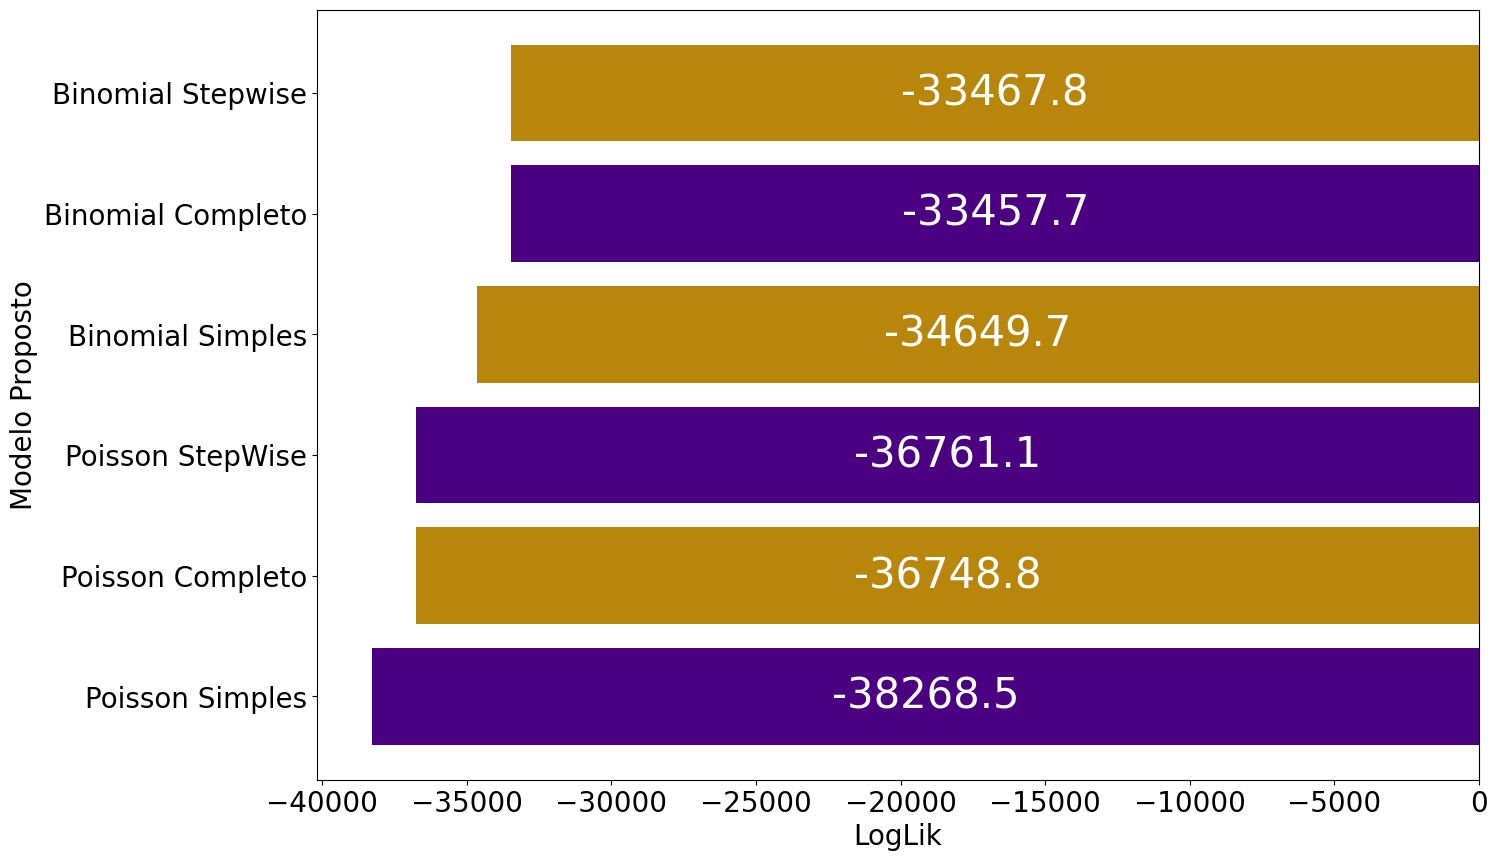

In [44]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [45]:
y = df['frauds'].copy()
X1 = df['transactions'].copy()
X1 = sm.add_constant(X1)

In [46]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zip_simples.summary()

         Current function value: 0.385232
         Iterations: 35
         Function evaluations: 67
         Gradient evaluations: 67


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86151
Model:             ZeroInflatedPoisson   Df Residuals:                    86149
Method:                            MLE   Df Model:                            1
Date:                 Tue, 27 May 2025   Pseudo R-squ.:                 0.05206
Time:                         02:52:27   Log-Likelihood:                -33188.
converged:                       False   LL-Null:                       -35011.
Covariance Type:             nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            0.7036      0.058     12.039      0.000       0.589       0.818
inflate_transactions     0.0016      0.000      4.583      0.000       0.001       0.002
const                   -3.8343      0.042    -90.786      0.000      -3.917      -3.752
transactions             0.0228      0.000     88.844      0.000       0.022       0.023
========================================================================================
"""

In [47]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 0.444203
         Iterations 6
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -42.119
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [48]:
df.columns

Index(['date_window', 'transactions', 'frauds', 'mean_amount', 'std_amount',
       'skew_amount', 'kurtosis_amount', 'mean_current_age', 'std_current_age',
       'skew_current_age', 'kurtosis_current_age', 'mean_per_capita_income',
       'std_per_capita_income', 'skew_per_capita_income',
       'kurtosis_per_capita_income', 'mean_total_debt', 'std_total_debt',
       'skew_total_debt', 'kurtosis_total_debt', 'mean_credit_score',
       'std_credit_score', 'skew_credit_score', 'kurtosis_credit_score',
       'mean_num_credit_cards', 'std_num_credit_cards',
       'skew_num_credit_cards', 'kurtosis_num_credit_cards',
       'mean_credit_limit', 'std_credit_limit', 'skew_credit_limit',
       'kurtosis_credit_limit', 'use_chip_online_transaction',
       'use_chip_swipe_transaction', 'use_chip_chip_transaction',
       'gender_female', 'card_brand_amex', 'card_brand_mastercard',
       'card_brand_visa', 'card_brand_discover', 'card_type_credit',
       'card_type_debit_prepaid', 'card

In [49]:
exclude_columns = [column for column in df.columns if 'std_' in column]
exclude_columns.extend([column for column in df.columns if 'skew_' in column])
exclude_columns.extend([column for column in df.columns if 'kurtosis_' in column])

In [50]:
X = df.drop(columns=['date_window', 'frauds']).drop(columns=exclude_columns).copy(deep=True)

In [51]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X)
X = pd.DataFrame(X_scaler, columns=X.columns)

In [52]:
X = sm.add_constant(X)

In [53]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X, exog_infl=X, inflation='logit').fit()
modelo_zip_complete.summary()

         Current function value: 0.368884
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86151
Model:             ZeroInflatedPoisson   Df Residuals:                    86112
Method:                            MLE   Df Model:                           38
Date:                 Tue, 27 May 2025   Pseudo R-squ.:                 0.09229
Time:                         02:54:06   Log-Likelihood:                -31780.
converged:                       False   LL-Null:                       -35011.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.4870      0.021     70.647      0.000       1.446       1.528
inflate_transactions                               -0.3258      0.028    -11.474      0.000      -0.381      -0.270
inflate_mean_amount                                -0.3069      0.030    -10.132      0.000      -0.366      -0.248
inflate_mean_current_age                           -0.0822      0.024     -3.404      0.001      -0.130      -0.035
inflate_mean_per_capita_income                     -0.1102      0.027     -4.131      0.000      -0.162      -0.058
inflate_mean_total_debt                             0.0795      0.023      3.510      0.000       0.035       0.124
inflate_mean_credit_score                          -0.1090      0.020     -5.458      0.000      -0.148      -0.070
inflate_mean_num_credit_cards                      -0.1617      0.024     -6.879      0.000      -0.208      -0.116
inflate_mean_credit_limit                           0.0190      0.027      0.695      0.487      -0.035       0.073
inflate_use_chip_online_transaction                -0.0254      0.350     -0.073      0.942      -0.712       0.661
inflate_use_chip_swipe_transaction                  0.1867      1.349      0.138      0.890      -2.457       2.830
inflate_use_chip_chip_transaction                   0.0353      1.328      0.027      0.979      -2.567       2.637
inflate_gender_female                              -0.1765      0.021     -8.425      0.000      -0.218      -0.135
inflate_card_brand_amex                             0.0570      0.088      0.646      0.518      -0.116       0.230
inflate_card_brand_mastercard                       0.1428      0.176      0.810      0.418      -0.203       0.488
inflate_card_brand_visa                             0.1013      0.173      0.587      0.557      -0.237       0.439
inflate_card_brand_discover                         0.0259      0.060      0.432      0.666      -0.092       0.144
inflate_card_type_credit                            0.1252      0.190      0.659      0.510      -0.247       0.497
inflate_card_type_debit_prepaid                    -0.0088      0.109     -0.081      0.935      -0.222       0.204
inflate_card_type_debit                             0.1076      0.203      0.530      0.596      -0.290       0.505
inflate_has_chip_yes                               -0.0764      0.019     -3.970      0.000      -0.114      -0.039
inflate_online_sales_no                             0.1867      0.280      0.666      0.506      -0.363       0.736
inflate_category_food_beverage                      0.0683      0.101      0.679      0.497      -0.129       0.265
inflate_category_retail_general_department          0.0417      0.057      0.734      0.463      -0.070       0.153
inflate_category_transportation_logistics           0.0829      0.084      0.987      0.324      -0.

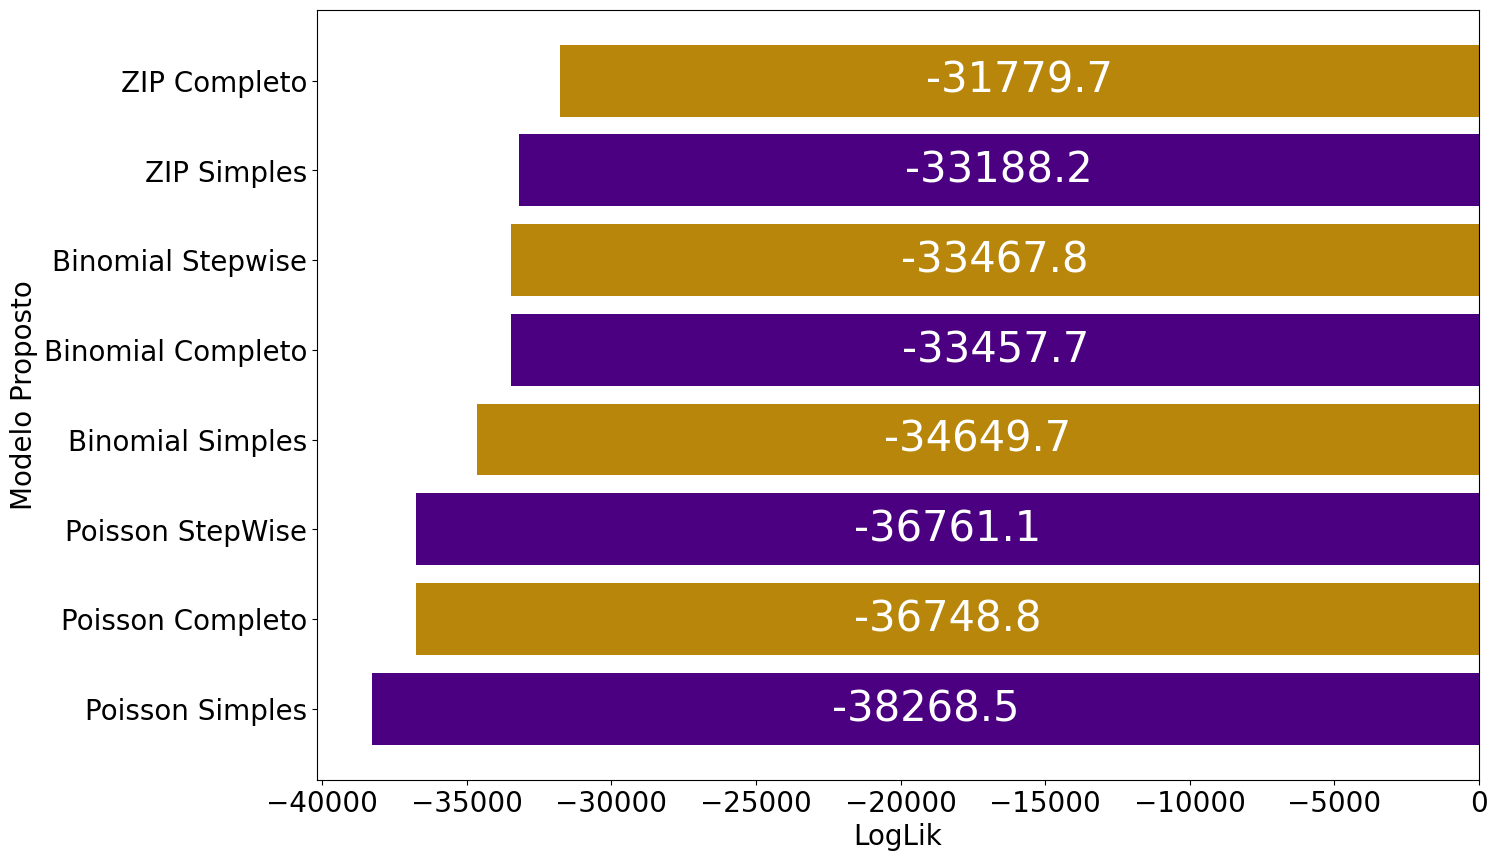

In [54]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [55]:
y = df['frauds'].copy()
X = df.drop(columns=['date_window', 'frauds']).drop(columns=exclude_columns)

In [56]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X)

X = pd.DataFrame(X_scaler, columns=X.columns)
X['frauds'] = y
X

,transactions,mean_amount,mean_current_age,mean_per_capita_income,mean_total_debt,mean_credit_score,mean_num_credit_cards,mean_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,...,category_travel_hospitality,category_health_medical,category_professional_business_services,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_manufacturing_industrial,category_retail_home_garden,category_personal_services,frauds
0,-1.243958,-1.328104,-0.189410,-1.253550,0.557653,2.186942,1.826253,-0.125431,0.348865,0.901529,...,-0.349381,-1.787991,-0.518463,-0.623120,-0.460915,-0.139341,-0.51915,-1.066960,-0.778979,0
1,-1.308179,0.099300,0.485967,1.070885,0.124347,2.422538,1.645986,3.486455,2.390929,0.568112,...,-0.349381,-1.787991,-0.518463,-0.623120,-0.460915,-0.139341,-0.51915,-1.066960,-0.778979,0
2,-1.260013,-0.323037,-0.944592,-0.143328,2.199524,1.242126,-1.908265,-0.204175,-0.842338,1.096022,...,2.071605,-0.687413,1.894354,2.369584,-0.460915,-0.139341,-0.51915,-1.066960,-0.778979,0
3,-1.324234,-0.738361,-0.655151,-0.433112,-1.551148,-0.302758,-0.762572,-0.053492,-0.501995,1.040453,...,-0.349381,-0.412268,-0.518463,3.117760,-0.460915,-0.139341,-0.51915,-1.066960,-0.778979,0
4,-1.404509,-0.542016,0.387798,-2.670603,-0.446279,-3.730173,1.206587,0.994716,1.029553,0.790390,...,-0.349381,-0.137124,-0.518463,-0.623120,5.333800,-0.139341,-0.51915,-1.066960,-0.778979,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86146,-0.296709,0.110519,-0.729857,-0.171326,0.574351,1.358276,-0.644633,0.479955,-0.331823,-1.098975,...,0.255866,0.138021,0.084742,-0.623120,0.504871,-0.139341,0.25045,-0.690334,1.125440,0
86147,-0.698086,0.017114,-1.356603,0.020174,-0.069639,-0.627585,0.025091,-1.039712,0.348865,-0.848912,...,1.466358,-0.412268,0.687946,0.873232,-0.460915,-0.139341,-0.51915,-1.066960,1.125440,0
86148,-0.425149,0.785582,-0.653233,1.841630,0.597638,-1.387467,-0.669578,1.066538,-0.672166,-1.071190,...,-0.349381,-0.137124,-0.518463,0.125056,-0.460915,-0.139341,-0.13435,0.816169,0.173230,0
86149,-0.633865,0.699257,-0.442870,1.082778,0.278652,-0.740948,0.065370,0.617493,0.689209,-1.126760,...,0.861112,-0.137124,0.687946,-0.623120,-0.460915,-0.139341,0.25045,-1.066960,1.125440,0


In [57]:
class ZeroInflatedModelEvaluator:
    def __init__(self, df: pd.DataFrame, dependent_var: str, independent_vars_names: list, debug=False):
        self.df = df
        self.dependent_var = dependent_var
        self.independent_vars_names = independent_vars_names
        self.num_total_features = len(independent_vars_names)
        self.debug = debug

        missing_cols = [col for col in independent_vars_names if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"Variáveis independentes ausentes no DataFrame: {missing_cols}")
        print(f"[Model Evaluator - Init] Inicializado para variável dependente: '{self.dependent_var}'.")

    def evaluate(self,
                 individual: list,
                 model_type: str = 'ZIP',
                 p_value_threshold: float = 0.05,
                 significance_penalty_factor: float = 100.0,
                 weights: dict|None = None,
                 return_model_summary: bool = False):

        # ➕ Pesos padrão das métricas
        # default_weights = {
        #     'aic': 0.3,
        #     'bic': 0.3,
        #     'rmse': 0.2,
        #     'auc': 0.2
        # }
        # if weights is None:
        #     weights = default_weights

        selected_features_count_idx = [i for i, gene in enumerate(individual[:self.num_total_features]) if gene == 1]
        selected_features_zero_idx = [i for i, gene in enumerate(individual[self.num_total_features:]) if gene == 1]

        if not selected_features_count_idx or not selected_features_zero_idx:
            if self.debug:
                print(f"  [Model Evaluator - {model_type}] Indivíduo inválido: Sem features para ambos os componentes. Fitness: inf.")
            return (float('inf'),)

        features_count = [self.independent_vars_names[i] for i in selected_features_count_idx]
        features_zero = [self.independent_vars_names[i] for i in selected_features_zero_idx]

        try:
            X_count = sm.add_constant(self.df[features_count])
            X_zero = sm.add_constant(self.df[features_zero])

            if model_type == 'ZIP':
                model = sm.ZeroInflatedPoisson(
                    endog=self.df[self.dependent_var],
                    exog=X_count,
                    exog_infl=X_zero,
                    inflation='logit'
                )
            elif model_type == 'ZINB':
                model = sm.ZeroInflatedNegativeBinomialP(
                    endog=self.df[self.dependent_var],
                    exog=X_count,
                    exog_infl=X_zero,
                    inflation='logit'
                )
            else:
                raise ValueError(f"Tipo de modelo inválido: {model_type}")

            model = model.fit(disp=0)

        except Exception as e:
            if self.debug:
                print(f"  [Model Evaluator - {model_type}] Falha ao treinar o modelo: {e}")
            return (float('inf'),)

        quantity = len(model.pvalues)
        p_values = model.pvalues.tolist()

        fitness = 1 - ((len(model.pvalues[model.pvalues < 0.05])) / (len(individual) + 2)) # +2 constantes

        if self.debug:
            print(f"  [Model Evaluator - {model_type}] Fitness Calculado: {fitness:.4f}")

        if return_model_summary:
            return (fitness, model)
        return (fitness,)

In [58]:
class ZeroInflatedGAOptimizer:
    """
    Classe responsável por executar o algoritmo genético para otimização
    da seleção de features para modelos Zero-Inflated Poisson (ZIP)
    ou Zero-Inflated Negative Binomial (ZINB).
    """
    def __init__(self, df: pd.DataFrame,
                 independent_vars_names: list[str],
                 dependent_var: str = 'frauds',
                 model_type: str = 'ZINB',
                 pop_size: int = 100,
                 num_generations: int = 50,
                 cx_prob: float = 0.7,
                 mut_prob: float = 0.1,
                 tourn_size: int = 3,
                 p_value_threshold: float = 0.05,
                 significance_penalty_factor: float = 100.0,
                 seed: int = 42,
                 n_jobs: int = -1,
                 debug=False): # Novo parâmetro para número de processos
        self.df = df
        self.independent_vars_names = independent_vars_names
        self.dependent_var = dependent_var
        self.model_type = model_type
        self.pop_size = pop_size
        self.num_generations = num_generations
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.tourn_size = tourn_size
        self.p_value_threshold = p_value_threshold
        self.significance_penalty_factor = significance_penalty_factor
        self.seed = seed
        self.n_jobs = n_jobs
        self.debug = debug

        random.seed(self.seed)
        np.random.seed(self.seed)
        print(f"[{self.model_type} Optimizer] Seed de aleatoriedade definida para: {self.seed}")

        self.num_total_features = len(self.independent_vars_names)
        print(f"[{self.model_type} Optimizer] Número total de features disponíveis: {self.num_total_features}")

        self.model_evaluator = ZeroInflatedModelEvaluator(
            df=self.df,
            dependent_var=self.dependent_var,
            independent_vars_names=self.independent_vars_names,
            debug=self.debug
        )
        print(f"[{self.model_type} Optimizer] Avaliador de modelo Zero-Inflated inicializado.")

        self.best_individual = None
        self.best_fitness = float('inf')
        self.logbook = None
        self.final_model_results = None
        self._setup_deap()
        print(f"[{self.model_type} Optimizer] Componentes DEAP configurados.")

    def _setup_deap(self):
        """Configura os componentes do DEAP (Fitness, Individual, Toolbox)."""
        if not hasattr(creator, "FitnessMin"):
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
            print(f"[{self.model_type} Optimizer] 'FitnessMin' criado para minimização.")
        if not hasattr(creator, "Individual"):
            creator.create("Individual", list, fitness=creator.FitnessMin)
            print(f"[{self.model_type} Optimizer] 'Individual' criado como lista com FitnessMin.")

        self.toolbox = base.Toolbox()
        self.toolbox.register("attr_bool", random.randint, 0, 1)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual,
                              self.toolbox.attr_bool, n=2 * self.num_total_features)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        self.toolbox.register("evaluate", partial(self.model_evaluator.evaluate,
                                                  model_type=self.model_type,
                                                  p_value_threshold=self.p_value_threshold,
                                                  significance_penalty_factor=self.significance_penalty_factor))

        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=self.mut_prob)
        self.toolbox.register("select", tools.selTournament, tournsize=self.tourn_size)
        print(f"[{self.model_type} Optimizer] Operadores genéticos (mate, mutate, select) registrados.")

        self.stats = tools.Statistics(lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)
        print(f"[{self.model_type} Optimizer] Estatísticas para o logbook registradas.")

        self.hof = tools.HallOfFame(1)
        print(f"[{self.model_type} Optimizer] Hall of Fame (tamanho 1) inicializado.")

    def optimize(self):
        """
        Executa o algoritmo genético para otimização da seleção de features.
        """
        print(f"\n--- Iniciando otimização para modelo {self.model_type} ---")
        pop = self.toolbox.population(n=self.pop_size)
        print(f"[{self.model_type} Optimizer] População inicial gerada com {self.pop_size} indivíduos.")

        # Configuração do Pool de processos para paralelização
        num_processes = self.n_jobs if self.n_jobs != -1 else os.cpu_count()
        print(f"[{self.model_type} Optimizer] Iniciando Pool de {num_processes} processos para avaliação paralela.")
        pool = Pool(processes=num_processes)
        self.toolbox.register("map", pool.map) # Sobrescreve o 'map' padrão do toolbox com o do Pool

        # Avaliar a geração inicial (gen 0)
        invalid_ind = [ind for ind in pop if not ind.fitness.valid]
        print(f"[{self.model_type} Optimizer] Avaliando {len(invalid_ind)} indivíduos da geração inicial (0) em paralelo...")
        fitnesses = self.toolbox.map(self.toolbox.evaluate, invalid_ind) # Agora usa pool.map
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        print(f"[{self.model_type} Optimizer] Avaliação da geração 0 concluída.")

        self.hof.update(pop)
        record = self.stats.compile(pop)
        self.logbook = tools.Logbook()
        self.logbook.header = ['gen', 'nevals'] + list(self.stats.fields) # Correção: usa .fields para o cabeçalho
        self.logbook.record(gen=0, nevals=len(invalid_ind), **record)
        print(str(self.logbook.stream))

        # Loop principal do algoritmo genético com barra de progresso do tqdm
        # Armazena a instância da barra de progresso para poder chamar .set_description() nela
        progress_bar = tqdm(range(1, self.num_generations + 1), desc=f"Evoluindo {self.model_type}", leave=True)
        for gen in progress_bar:
            offspring = self.toolbox.select(pop, len(pop))
            offspring = list(map(self.toolbox.clone, offspring))

            # Aplicação de cruzamento (crossover)
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.cx_prob:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicação de mutação
            for mutant in offspring:
                if random.random() < self.mut_prob:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Avaliar os indivíduos modificados que perderam seu fitness (invalid_ind)
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = self.toolbox.map(self.toolbox.evaluate, invalid_ind) # Continua usando pool.map
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            # Atualizar a população e o Hall of Fame
            pop[:] = offspring
            self.hof.update(pop)

            # Registrar estatísticas da geração no logbook
            record = self.stats.compile(pop)
            self.logbook.record(gen=gen, nevals=len(invalid_ind), **record)

            # Atualizar a descrição da barra de progresso do tqdm
            current_min = record.get("min", float('inf'))
            current_avg = record.get("avg", float('inf'))
            tqdm_desc = (f"Evoluindo {self.model_type} (Gen: {gen}/{self.num_generations}, "
                         f"Min Fit: {current_min:.2f}, Avg Fit: {current_avg:.2f})")
            progress_bar.set_description(tqdm_desc) # Correção: chama set_description na instância

        # Fim do loop principal
        self.best_individual = self.hof[0]
        self.best_fitness = self.best_individual.fitness.values[0]
        print(f"[{self.model_type} Optimizer] Otimização concluída. Melhor fitness encontrado: {self.best_fitness:.4f}")

        print(f"[{self.model_type} Optimizer] Treinando modelo final com o melhor indivíduo encontrado...")
        # Recupera as features selecionadas pelo melhor indivíduo para logs
        selected_features_count_idx_best = [i for i in range(self.num_total_features) if self.best_individual[i] == 1]
        selected_features_zero_idx_best = [i for i in range(self.num_total_features) if self.best_individual[i + self.num_total_features] == 1]
        best_features_count_names = [self.independent_vars_names[i] for i in selected_features_count_idx_best]
        best_features_zero_names = [self.independent_vars_names[i] for i in selected_features_zero_idx_best]

        print(f"[{self.model_type} Optimizer] Features do melhor indivíduo para Contagem: {best_features_count_names}")
        print(f"[{self.model_type} Optimizer] Features do melhor indivíduo para Zero-Inflated: {best_features_zero_names}")

        # Avaliação final do modelo (sem paralelização, para obter o summary do modelo)
        _, self.final_model_results = self.model_evaluator.evaluate(
            self.best_individual, model_type=self.model_type, return_model_summary=True,
            p_value_threshold=self.p_value_threshold, significance_penalty_factor=self.significance_penalty_factor
        )
        print(f"[{self.model_type} Optimizer] Modelo final treinado.")
        self._report_results()

        # Encerramento do Pool de processos
        pool.close() # Indica que nenhum novo trabalho será enviado
        pool.join()  # Espera que todos os processos worker terminem
        print(f"[{self.model_type} Optimizer] Pool de processos encerrado.")


    def get_features_model(self):
        """Retorna as features selecionadas pelo melhor indivíduo."""
        selected_features_count_idx = [i for i in range(self.num_total_features)
                                       if self.best_individual[i] == 1]
        selected_features_zero_idx = [i for i in range(self.num_total_features)
                                      if self.best_individual[i + self.num_total_features] == 1]

        best_features_count = [self.independent_vars_names[i] for i in selected_features_count_idx]
        best_features_zero = [self.independent_vars_names[i] for i in selected_features_zero_idx]

        return dict(feature_count=best_features_count, feature_zero=best_features_zero)

    def _report_results(self):
        result = self.get_features_model()
        best_features_count = result['feature_count']
        best_features_zero = result['feature_zero']

        print("\n--- Resultados da Otimização ---")
        print(f"[{self.model_type} Optimizer] Melhor fitness (AIC + Penalidade de Significância): {self.best_fitness:.4f}")
        print(f"[{self.model_type} Optimizer] Melhores features para o componente de contagem: {best_features_count}")
        print(f"[{self.model_type} Optimizer] Melhores features para o componente zero-inflated: {best_features_zero}")

        print("\n--- Sumário do Modelo Final ---")
        if self.final_model_results:
            print(self.final_model_results.summary())
        else:
            print(f"[{self.model_type} Optimizer] Não foi possível treinar o modelo final com as melhores features.")



In [59]:
print("Executando otimização para ZIP...")
zip_optimizer = ZeroInflatedGAOptimizer(
    df=X,
    independent_vars_names=X.drop(columns=['frauds']).columns.tolist(),
    dependent_var='frauds',
    model_type='ZIP',
    pop_size=8,
    num_generations=30,
    p_value_threshold=0.05,
    significance_penalty_factor=500.0,
    mut_prob=0.2,
)
zip_optimizer.optimize()

Executando otimização para ZIP...
[ZIP Optimizer] Seed de aleatoriedade definida para: 42
[ZIP Optimizer] Número total de features disponíveis: 38
[Model Evaluator - Init] Inicializado para variável dependente: 'frauds'.
[ZIP Optimizer] Avaliador de modelo Zero-Inflated inicializado.
[ZIP Optimizer] 'FitnessMin' criado para minimização.
[ZIP Optimizer] 'Individual' criado como lista com FitnessMin.
[ZIP Optimizer] Operadores genéticos (mate, mutate, select) registrados.
[ZIP Optimizer] Estatísticas para o logbook registradas.
[ZIP Optimizer] Hall of Fame (tamanho 1) inicializado.
[ZIP Optimizer] Componentes DEAP configurados.

--- Iniciando otimização para modelo ZIP ---
[ZIP Optimizer] População inicial gerada com 8 indivíduos.
[ZIP Optimizer] Iniciando Pool de 8 processos para avaliação paralela.
[ZIP Optimizer] Avaliando 8 indivíduos da geração inicial (0) em paralelo...
[ZIP Optimizer] Avaliação da geração 0 concluída.
gen	nevals	avg     	std     	min     	max
0  	8     	0.709936	0

Evoluindo ZIP (Gen: 30/30, Min Fit: 0.54, Avg Fit: 0.54): 100%|██████████| 30/30 [16:58<00:00, 33.94s/it]


[ZIP Optimizer] Otimização concluída. Melhor fitness encontrado: 0.5385
[ZIP Optimizer] Treinando modelo final com o melhor indivíduo encontrado...
[ZIP Optimizer] Features do melhor indivíduo para Contagem: ['transactions', 'mean_current_age', 'mean_per_capita_income', 'mean_total_debt', 'mean_credit_limit', 'use_chip_online_transaction', 'card_brand_amex', 'card_brand_visa', 'card_type_credit', 'card_type_debit', 'has_chip_yes', 'category_food_beverage', 'category_retail_general_department', 'category_transportation_logistics', 'category_financial_insurance', 'category_retail_specialty', 'category_health_medical', 'category_professional_business_services', 'category_retail_clothing_accessories', 'category_construction_contractors', 'category_personal_services']
[ZIP Optimizer] Features do melhor indivíduo para Zero-Inflated: ['transactions', 'mean_per_capita_income', 'mean_credit_score', 'mean_credit_limit', 'use_chip_chip_transaction', 'card_brand_amex', 'card_brand_visa', 'card_bra

Não utilizados

mean_per_capita_income

mean_total_debt

mean_credit_score

mean_num_credit_cards

mean_credit_limit

use_chip_swipe_transaction

gender_female

card_brand_amex

card_brand_discover

card_type_credit

card_type_debit_prepaid

has_chip_no

online_sales_no

'category_financial_insurance'

'category_retail_general_department'

, 'category_retail_specialty'

, 'category_government_utilities'

, 'category_technology_telecommunications'

, 'category_arts_entertainment_recreation'

, 'category_travel_hospitality'

, 'category_professional_business_services'

 'category_health_medical'

 , 'category_retail_clothing_accessories'

 , 'category_sports_recreation'

 , 'category_construction_contractors'

 , 'category_retail_home_garden'

 , 'category_manufacturing_industrial'

In [61]:
y = df['frauds'].copy()
X1 = df[['transactions', 'mean_amount', 'mean_current_age', 'use_chip_online_transaction', 'use_chip_chip_transaction', 'card_type_debit', 'category_transportation_logistics', 'category_food_beverage']].copy()
X1 = sm.add_constant(X1)

X2 = df[['transactions', 'use_chip_online_transaction', 'use_chip_chip_transaction', 'card_brand_visa', 'card_brand_mastercard']].copy()
X2 = sm.add_constant(X2)

modelo_zip_stepwise = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zip_stepwise.summary()

         Current function value: 0.417103
         Iterations: 35
         Function evaluations: 61
         Gradient evaluations: 61


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86151
Model:             ZeroInflatedPoisson   Df Residuals:                    86142
Method:                            MLE   Df Model:                            8
Date:                 Tue, 27 May 2025   Pseudo R-squ.:                -0.02636
Time:                         03:15:21   Log-Likelihood:                -35934.
converged:                       False   LL-Null:                       -35011.
Covariance Type:             nonrobust   LLR p-value:                     1.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
inflate_const                           0.8396        nan        nan        nan         nan         nan
inflate_transactions                   -0.0104        nan        nan        nan         nan         nan
inflate_use_chip_online_transaction     0.2079        nan        nan        nan         nan         nan
inflate_use_chip_chip_transaction       0.6837        nan        nan        nan         nan         nan
inflate_card_brand_visa                 0.4223        nan        nan        nan         nan         nan
inflate_card_brand_mastercard           0.4076        nan        nan        nan         nan         nan
const                                  -6.6074        nan        nan        nan         nan         nan
transactions                            0.0156        nan        nan        nan         nan         nan
mean_amount                            -0.0030        nan        nan        nan         nan         nan
mean_current_age                        0.0980        nan        nan        nan         nan         nan
use_chip_online_transaction             8.9537        nan        nan        nan         nan         nan
use_chip_chip_transaction               0.6855        nan        nan        nan         nan         nan
card_type_debit                        -3.2162        nan        nan        nan         nan         nan
category_transportation_logistics      -3.3468        nan        nan        nan         nan         nan
category_food_beverage                 -1.9356        nan        nan        nan         nan         nan
=======================================================================================================
"""

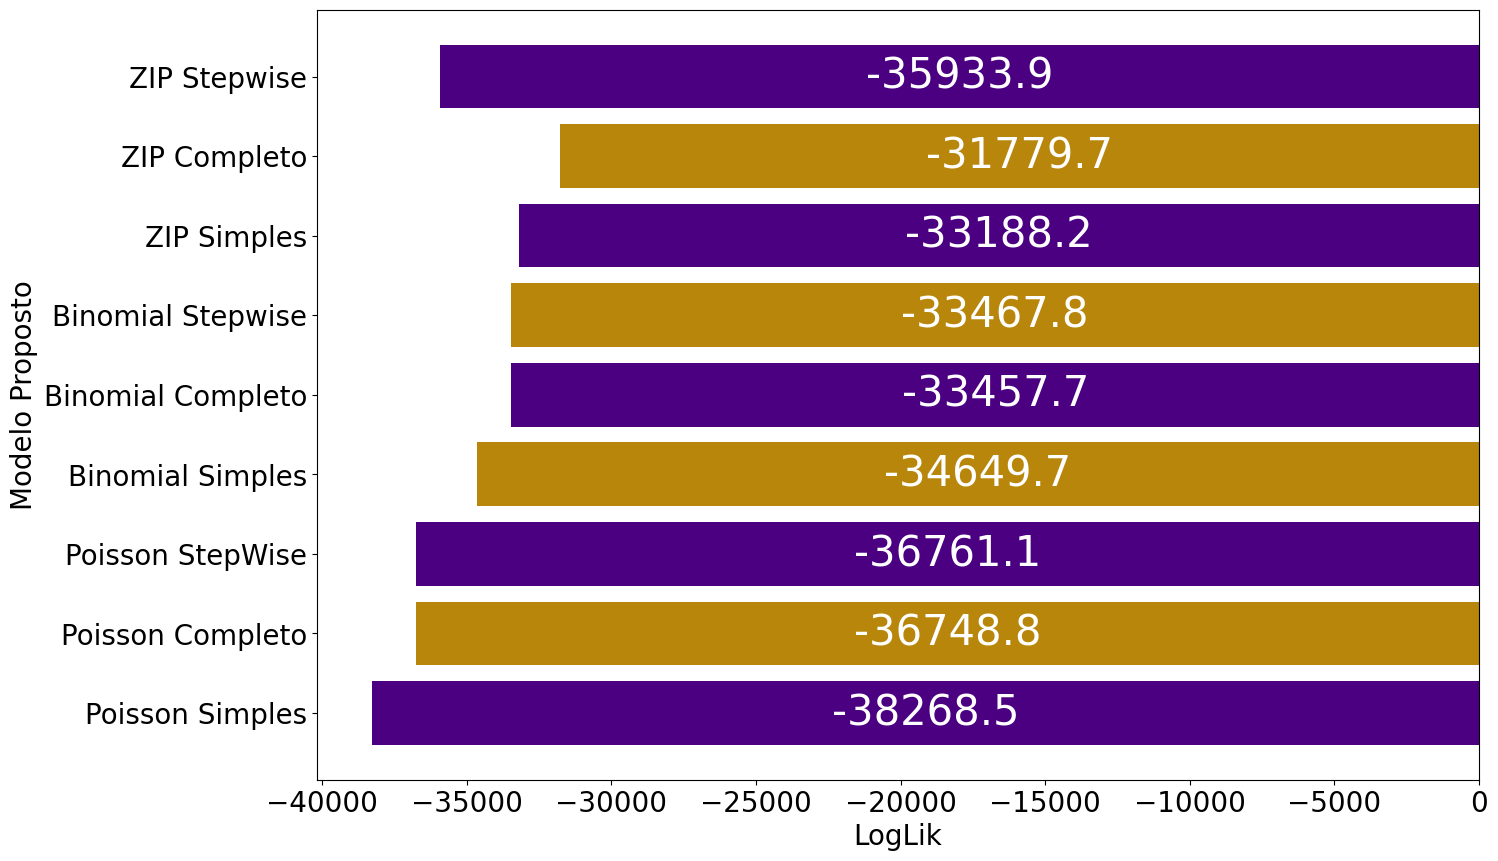

In [62]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [63]:
y = X['frauds'].copy()
X1 = X['transactions'].copy()

X1 = sm.add_constant(X1)

In [64]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_simples.summary()

         Current function value: 0.374623
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86151
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86149
Method:                                      MLE   Df Model:                            1
Date:                           Tue, 27 May 2025   Pseudo R-squ.:                 0.07373
Time:                                   03:15:55   Log-Likelihood:                -32274.
converged:                                 False   LL-Null:                       -34843.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const           -0.5585      0.143     -3.900      0.000      -0.839      -0.278
inflate_transactions    -1.6467      0.083    -19.888      0.000      -1.809      -1.484
const                   -1.7149      0.050    -34.406      0.000      -1.813      -1.617
transactions             0.5560      0.033     16.658      0.000       0.491       0.621
alpha                    5.2227      0.220     23.745      0.000       4.792       5.654
========================================================================================
"""

In [65]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 0.376742
         Iterations: 19
         Function evaluations: 29
         Gradient evaluations: 29
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -10.005
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [68]:
y = X['frauds']
X1 = X.drop(columns=['frauds']).copy()
X1 = sm.add_constant(X1)

modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_complete.summary()

         Current function value: 0.387698
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86151
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86112
Method:                                      MLE   Df Model:                           38
Date:                           Tue, 27 May 2025   Pseudo R-squ.:                 0.04140
Time:                                   03:21:37   Log-Likelihood:                -33401.
converged:                                 False   LL-Null:                       -34843.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                      -7.0863        nan        nan        nan         nan         nan
inflate_transactions                               -3.8766        nan        nan        nan         nan         nan
inflate_mean_amount                                 0.6937        nan        nan        nan         nan         nan
inflate_mean_current_age                           -0.7331        nan        nan        nan         nan         nan
inflate_mean_per_capita_income                      0.2030        nan        nan        nan         nan         nan
inflate_mean_total_debt                             0.0508        nan        nan        nan         nan         nan
inflate_mean_credit_score                           0.2561        nan        nan        nan         nan         nan
inflate_mean_num_credit_cards                      -0.0792        nan        nan        nan         nan         nan
inflate_mean_credit_limit                           0.1745        nan        nan        nan         nan         nan
inflate_use_chip_online_transaction                -0.4340        nan        nan        nan         nan         nan
inflate_use_chip_swipe_transaction                 -0.3152        nan        nan        nan         nan         nan
inflate_use_chip_chip_transaction                   0.3942        nan        nan        nan         nan         nan
inflate_gender_female                              -0.3188        nan        nan        nan         nan         nan
inflate_card_brand_amex                             0.0906        nan        nan        nan         nan         nan
inflate_card_brand_mastercard                      -0.2600        nan        nan        nan         nan         nan
inflate_card_brand_visa                             0.2235        nan        nan        nan         nan         nan
inflate_card_brand_discover                         0.0107        nan        nan        nan         nan         nan
inflate_card_type_credit                            0.0253        nan        nan        nan         nan         nan
inflate_card_type_debit_prepaid                    -0.2082        nan        nan        nan         nan         nan
inflate_card_type_debit                             0.1064        nan        nan        nan         nan         nan
inflate_has_chip_yes                                0.1525        nan        nan        nan         nan         nan
inflate_online_sales_no                             0.3268        nan        nan        nan         nan         nan
inflate_category_food_beverage                     -0.0592        nan        nan        nan         nan         nan
inflate_category_retail_general_department         -0.0787        nan        nan        nan         nan         nan
inflate_ca

In [69]:
dispersion = df.drop(columns='date_window').agg(['mean', 'var']).T.assign(overdispersion=lambda x: x['var'] > x['mean'], underdispersion=lambda x: x['var'] < x['mean'])
dispersion.head()

,mean,var,overdispersion,underdispersion
transactions,103.480668,3879.538358,True,False
frauds,0.154752,0.352906,True,False
mean_amount,46.634533,291.377021,True,False
std_amount,79.750805,1232.055809,True,False
skew_amount,1.717377,5.767180,True,False


In [70]:
dispersion.query('overdispersion == False').index.to_list()

['mean_current_age',
 'std_current_age',
 'skew_current_age',
 'skew_per_capita_income',
 'skew_total_debt',
 'mean_credit_score',
 'mean_num_credit_cards',
 'std_num_credit_cards',
 'skew_num_credit_cards',
 'skew_credit_limit',
 'use_chip_online_transaction',
 'use_chip_swipe_transaction',
 'use_chip_chip_transaction',
 'gender_female',
 'card_brand_amex',
 'card_brand_mastercard',
 'card_brand_visa',
 'card_brand_discover',
 'card_type_credit',
 'card_type_debit_prepaid',
 'card_type_debit',
 'has_chip_yes',
 'online_sales_no',
 'category_food_beverage',
 'category_retail_general_department',
 'category_transportation_logistics',
 'category_financial_insurance',
 'category_retail_specialty',
 'category_technology_telecommunications',
 'category_arts_entertainment_recreation',
 'category_government_utilities',
 'category_travel_hospitality',
 'category_health_medical',
 'category_professional_business_services',
 'category_retail_clothing_accessories',
 'category_sports_recreation',


In [71]:
df_standard = df.copy()
y = df_standard['frauds']
X = df_standard.drop(columns=['frauds', 'date_window'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,transactions,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,...,category_government_utilities,category_travel_hospitality,category_health_medical,category_professional_business_services,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_manufacturing_industrial,category_retail_home_garden,category_personal_services
0,-1.243958,-1.328104,-1.179430,-0.982553,-0.725444,-0.189410,-0.494798,2.656067,4.053808,-1.253550,...,-0.983100,-0.349381,-1.787991,-0.518463,-0.623120,-0.460915,-0.139341,-0.51915,-1.06696,-0.778979
1,-1.308179,0.099300,-0.329318,-0.085058,-0.601518,0.485967,-1.129803,1.484841,1.696132,1.070885,...,3.293147,-0.349381,-1.787991,-0.518463,-0.623120,-0.460915,-0.139341,-0.51915,-1.06696,-0.778979
2,-1.260013,-0.323037,-0.797890,-0.054806,-0.683933,-0.944592,1.105847,2.699910,2.353830,-0.143328,...,0.238685,2.071605,-0.687413,1.894354,2.369584,-0.460915,-0.139341,-0.51915,-1.06696,-0.778979
3,-1.324234,-0.738361,-0.455169,-0.837937,-0.674337,-0.655151,0.398207,0.451396,-0.899556,-0.433112,...,0.544131,-0.349381,-0.412268,-0.518463,3.117760,-0.460915,-0.139341,-0.51915,-1.06696,-0.778979
4,-1.404509,-0.542016,-0.979444,0.041968,-0.624683,0.387798,-1.195665,0.417585,1.133243,-2.670603,...,-0.983100,-0.349381,-0.137124,-0.518463,-0.623120,5.333800,-0.139341,-0.51915,-1.06696,-0.778979


In [72]:
X1 = X_scaled[['transactions', 'mean_credit_score',]].copy()
X1 = sm.add_constant(X1)

X2 = X_scaled[['transactions', 'mean_amount', 'mean_current_age', 'mean_credit_score', 'use_chip_online_transaction']].copy()
X2 = sm.add_constant(X1)


modelo_zinb_stepwise = ZeroInflatedNegativeBinomialP(y, X1, inflation='logit').fit(max_iter=200)
modelo_zinb_stepwise.summary()

         Current function value: 0.376554
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86151
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86148
Method:                                      MLE   Df Model:                            2
Date:                           Tue, 27 May 2025   Pseudo R-squ.:                 0.06896
Time:                                   03:22:08   Log-Likelihood:                -32441.
converged:                                 False   LL-Null:                       -34843.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_const        -1.8986        nan        nan        nan         nan         nan
const                -2.2260        nan        nan        nan         nan         nan
transactions          1.0718        nan        nan        nan         nan         nan
mean_credit_score    -0.0766        nan        nan        nan         nan         nan
alpha                 4.9855        nan        nan        nan         nan         nan
=====================================================================================
"""

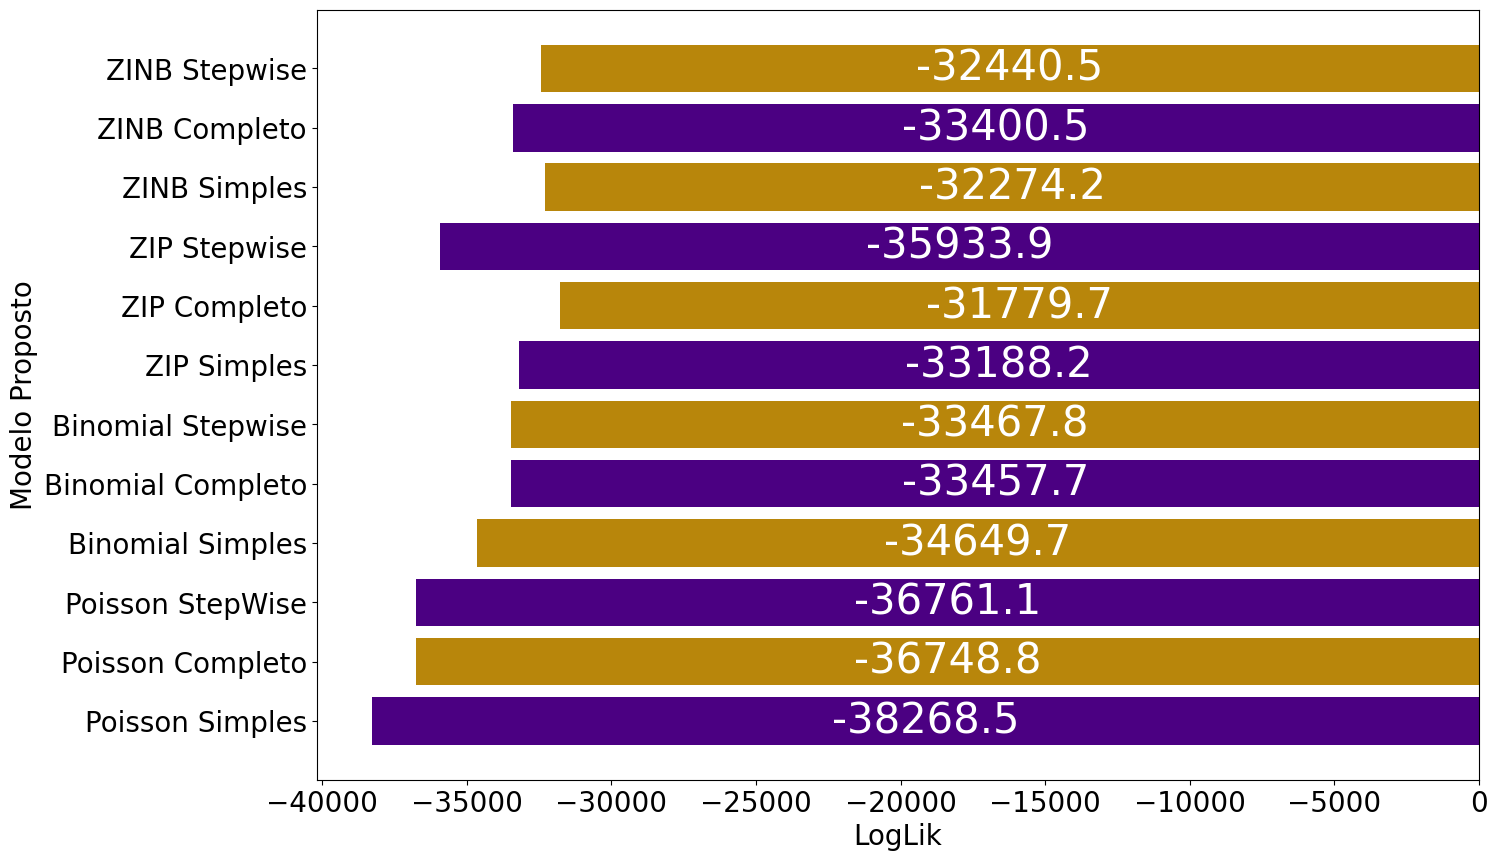

In [73]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_stepwise.llf
      ]
})